Imports

In [202]:
import feed_forward
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
import helper
torch.cuda.is_available()

True

CUDA check

In [203]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Data Transformation

In [204]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

Training and Test data from MNIST data set

In [205]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
n_inputs = 784
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=True)

Initializing the model

In [206]:
model = feed_forward.HypFF()
model.to(device)

HypFF(
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)

In [207]:
print(model)

HypFF(
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)


Hyperparameters

In [208]:
#learning_rate = 16e-4
learning_rate = 2e-1
momentum = 0.9

Loss Function

In [209]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)
images = 0.0357*images.view(images.shape[0], -1)

out = model(images) #output
print(out)
loss = criterion(out, labels) #calculate the loss

tensor([[ 0.0374, -0.0477, -0.0111,  ...,  0.0951,  0.0022,  0.0168],
        [ 0.0203, -0.0545, -0.0251,  ...,  0.0947, -0.0069,  0.0272],
        [ 0.0450, -0.0522, -0.0068,  ...,  0.0820,  0.0146,  0.0285],
        ...,
        [ 0.0248, -0.0553, -0.0110,  ...,  0.0848,  0.0143,  0.0189],
        [ 0.0302, -0.0461, -0.0046,  ...,  0.0870,  0.0028,  0.0262],
        [ 0.0347, -0.0518, -0.0040,  ...,  0.0890, -0.0174,  0.0211]],
       device='cuda:0', grad_fn=<SWhereBackward>)


Optimizer

In [210]:
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [211]:

time0 = time()

epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = 0.0357*images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #backpropagation
        loss.backward()
        
        #Weight optimization
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.834037165520555
Epoch 1 - Training loss: 1.660454516693697
Epoch 2 - Training loss: 1.6410405029684811
Epoch 3 - Training loss: 1.6324574937254697
Epoch 4 - Training loss: 1.6284777350344901
Epoch 5 - Training loss: 1.6246196082082844
Epoch 6 - Training loss: 1.6231947672569145
Epoch 7 - Training loss: 1.6194857439752353
Epoch 8 - Training loss: 1.6168246087381395
Epoch 9 - Training loss: 1.6109006273544442

Training Time (in minutes) = 2.4908801237742106


Predicted Digit = 1


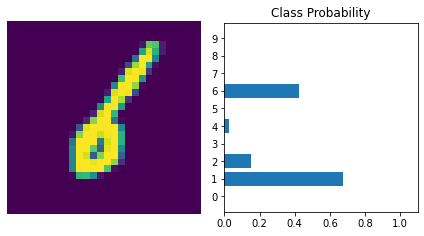

In [218]:
images, labels = next(iter(valloader))
#images, labels = images.to(device), labels.to(device)

img = 0.0357*images[0].view(1, 784)
img_gpu = img.to(device)
with torch.no_grad():
    out = model(img_gpu)

ps = out.cpu()
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
helper.view_classify(img.view(1, 28, 28), ps)

In [213]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  images, labels = images.to(device), labels.to(device)
  for i in range(len(labels)):
    img = 0.0357*images[i].view(1, 784)
    with torch.no_grad():
        out = model(img)

    
    ps = out.cpu()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9046
